In [ ]:
#preliminary setup
%pip install -r requirements.txt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F


#Fetching the data
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

# set seeds for reproducibility
random_seed = 302
torch.manual_seed(302); np.random.seed(302)

X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.125, random_state=random_seed)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.20, random_state=random_seed, )

Note: you may need to restart the kernel to use updated packages.


Training set
size: (14448, 8)
          MedInc   HouseAge   AveRooms   AveBdrms   Population   AveOccup   Latidue   Longitude
mean        3.86      28.65       5.43        1.1     1421.79        3.13      35.64    -119.58
 std        1.89      12.58       2.41       0.43     1110.97       12.39       2.14       2.01
 min         0.5        1.0       0.85       0.33         6.0        0.69      32.54    -124.35
 max        15.0       52.0     141.91      25.64     35682.0     1243.33      41.95    -114.47


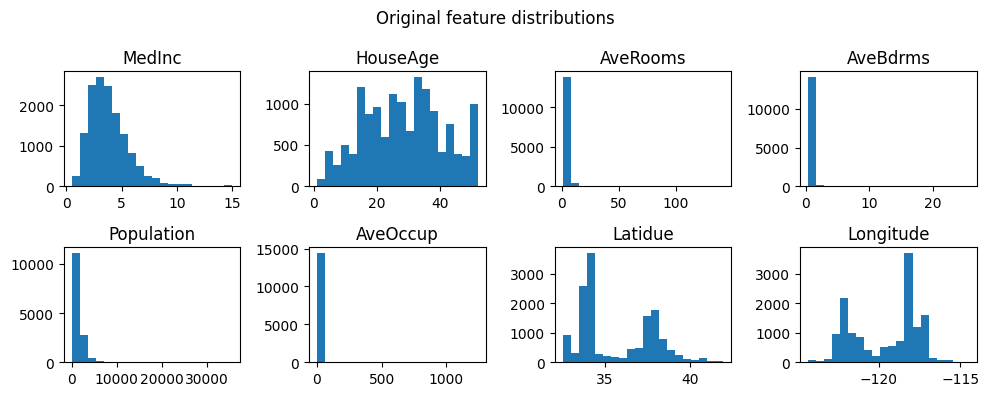

Training set
size: (14448, 8)
          MedInc   HouseAge   AveRooms   AveBdrms   Population   AveOccup   Latidue   Longitude
mean        -0.0      -0.01       -0.0       -0.0        -0.0        -0.0       -0.0       -0.0
 std        0.17       0.46       0.02       0.02        0.03        0.01       0.34       0.39
 min        -0.3      -1.03      -0.03      -0.03       -0.04        -0.0      -0.49      -0.94
 max         1.0       0.84        1.0        1.0         1.0         1.0        1.0        1.0


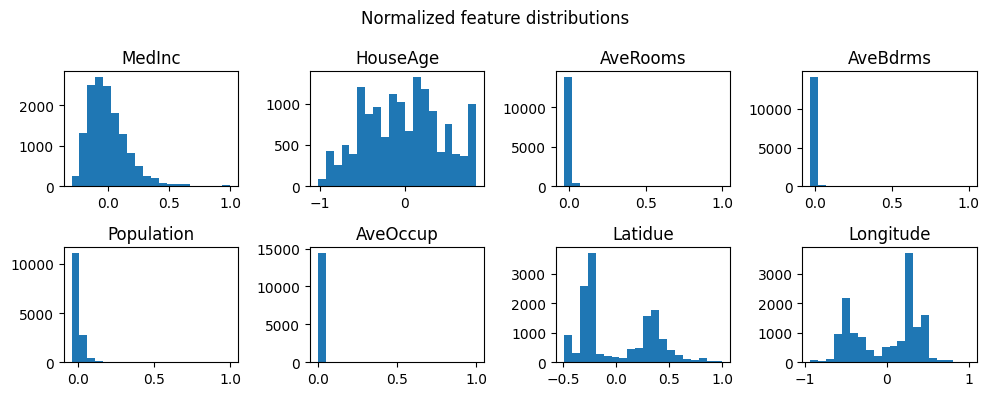

In [10]:
ONLY_TRAINING_SET = True
#a.) Investigating the dataset

all_sets = [X_train,y_train,X_validation,y_validation,X_test,y_test]
all_sets_names = ["Training set","Training targtets","Validation set","Validation targets","Test set","Test targets"]
features = ["MedInc","HouseAge","AveRooms","AveBdrms","Population","AveOccup","Latidue","Longitude"]
if ONLY_TRAINING_SET:
    all_sets = [X_train, y_train]
    all_sets_names = ["Training set","Training targtets"]


#Checking the data, to see what would be good to normalize
for set, name in zip(all_sets[0::2],all_sets_names[0::2]):
    
    print('\033[4m'+'\033[1m'+f"{name}"+'\033[0m'+'\033[0m')
    print(f"size: {str(set.shape) : >10}")
    stats = {"mean":[],
             "std":[],
             "min":[],
             "max":[]}
    fig,axs = plt.subplots(2,len(features)//2,figsize=(10,4),layout = "tight")
    for col,feature in enumerate(features):
        feature_data = set[:,col]
        stats["mean"].append(np.mean(feature_data))
        stats["std"].append(np.std(feature_data))
        stats["min"].append(np.min(feature_data))
        stats["max"].append(np.max(feature_data))
        axs[int(np.floor(col/4))][(col%4)].hist(feature_data,bins=20)
        axs[int(np.floor(col/4))][(col%4)].set_title(feature)
        

    print('\033[1m'+"          "+f"{'   '.join(features)}"+'\033[0m')
    for stat,vals in stats.items():
        x = [str(round(val,2)) for val in vals]
        print('{:>4}{:>12s}{:>11s}{:>11s}{:>11s}{:>12s}{:>12s}{:>11s}{:>11s}'.format(stat,x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]))
    
    plt.suptitle("Original feature distributions")
    plt.show()
    fig.savefig(f"./plots/{'feature distributions'}.png")

#Normalizing data
normalized_sets = []
for i,set in enumerate(all_sets[0::2]):
    new_set = np.zeros_like(set)
    for col in range(len(features)):

        norm_feature = np.reshape(set[:,col],(1,len(set[:,col])))
        
        #Standard gauss distribution
        norm_feature = (norm_feature-np.mean(norm_feature))/np.std(norm_feature)
        all_sets[i*2][:,col] = norm_feature
        
        #min-max scaling into -1 +1 range
        norm_feature = (norm_feature-np.min(np.abs(norm_feature)))/(np.max(np.abs(norm_feature))-np.min(np.abs(norm_feature)))
        new_set[:,col] = norm_feature

    normalized_sets.append(new_set)

for i,(set,name) in enumerate(zip(normalized_sets[0::2],all_sets_names[0::2])):
    print('\033[4m'+'\033[1m'+f"{name}"+'\033[0m'+'\033[0m')
    print(f"size: {str(set.shape) : >10}")
    stats = {"mean":[],
                "std":[],
                "min":[],
                "max":[]}
    fig,axs = plt.subplots(2,len(features)//2,figsize=(10,4),layout = "tight")
    for col,feature in enumerate(features):
        feature_data = set[:,col]
        stats["mean"].append(np.mean(feature_data))
        stats["std"].append(np.std(feature_data))
        stats["min"].append(np.min(feature_data))
        stats["max"].append(np.max(feature_data))
        axs[int(np.floor(col/4))][(col%4)].hist(feature_data,bins=20)
        axs[int(np.floor(col/4))][(col%4)].set_title(feature)
        

    print('\033[1m'+"          "+f"{'   '.join(features)}"+'\033[0m')
    for stat,vals in stats.items():
        x = [str(round(val,2)) for val in vals]
        print('{:>4}{:>12s}{:>11s}{:>11s}{:>11s}{:>12s}{:>12s}{:>11s}{:>11s}'.format(stat,x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]))

    plt.suptitle("Normalized feature distributions")
    plt.show()
    fig.savefig(f"./plots/{'normalized feature distributions'}.png")


## Networks

In [11]:
from models import NeuralNet_deep, NeuralNet_wide, NeuralNet_default, NeuralNet_deep_wider, NeuralNet_deeper_wide

def train_model(model, train_loader, val_loader, device, optimizer=None, num_epochs=5):
    loss_fn = nn.MSELoss()
    train_losses = []
    val_losses = []
    val_accuracies = []
    for epoch in range(num_epochs):
        print('-'*20, f'Epoch {epoch}', '-'*20)
        # Train one epoch
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            if optimizer is not None:
                optimizer.zero_grad()
            predict = model(data)
            loss = loss_fn(predict, target)
            loss.backward()
            if optimizer is not None:
                optimizer.step()

            train_losses.append(loss.item())

        print(f'Train Epoch {epoch} | Average Training Loss {np.mean(train_losses[-len(train_loader):])}')
        
        # Evaluate on validation set
        model.eval()
        val_loss = 0
        # correct = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                predict = model(data)
                val_loss += F.mse_loss(predict, target, reduction='sum').item()  # sum up batch loss
                # correct += (predict == target).sum().item()

        val_loss /= len(val_loader.dataset)
        # avg_correct = correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        # val_accuracies.append(avg_correct)

        print(f'Validation set: Average loss: {val_loss:.4f}, Accuracy: {0}/{len(val_loader.dataset)} ({100. * 0:.0f}%)\n')
    
    return train_losses, val_losses, val_accuracies


NeuralNet_deep
-------------------- Epoch 0 --------------------
Train Epoch 0 | Average Training Loss 5.448813012215943
Validation set: Average loss: 598.8379, Accuracy: 0/3612 (0%)

-------------------- Epoch 1 --------------------
Train Epoch 1 | Average Training Loss 5.448273612334665
Validation set: Average loss: 598.8379, Accuracy: 0/3612 (0%)

-------------------- Epoch 2 --------------------
Train Epoch 2 | Average Training Loss 5.445986957676642
Validation set: Average loss: 598.8379, Accuracy: 0/3612 (0%)

-------------------- Epoch 3 --------------------
Train Epoch 3 | Average Training Loss 5.447571209046693
Validation set: Average loss: 598.8379, Accuracy: 0/3612 (0%)

-------------------- Epoch 4 --------------------
Train Epoch 4 | Average Training Loss 5.447819073643305
Validation set: Average loss: 598.8379, Accuracy: 0/3612 (0%)



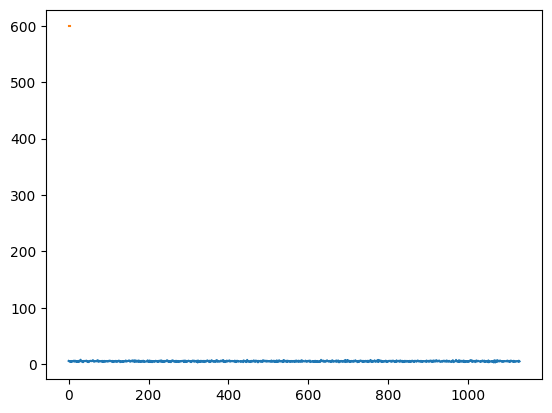

NeuralNet_wide
-------------------- Epoch 0 --------------------
Train Epoch 0 | Average Training Loss 5.538380016267827
Validation set: Average loss: 39.7795, Accuracy: 0/3612 (0%)

-------------------- Epoch 1 --------------------
Train Epoch 1 | Average Training Loss 5.538215662525818
Validation set: Average loss: 39.7795, Accuracy: 0/3612 (0%)

-------------------- Epoch 2 --------------------
Train Epoch 2 | Average Training Loss 5.537912532291581
Validation set: Average loss: 39.7795, Accuracy: 0/3612 (0%)

-------------------- Epoch 3 --------------------
Train Epoch 3 | Average Training Loss 5.537478586213779
Validation set: Average loss: 39.7795, Accuracy: 0/3612 (0%)

-------------------- Epoch 4 --------------------
Train Epoch 4 | Average Training Loss 5.538853807786925
Validation set: Average loss: 39.7795, Accuracy: 0/3612 (0%)



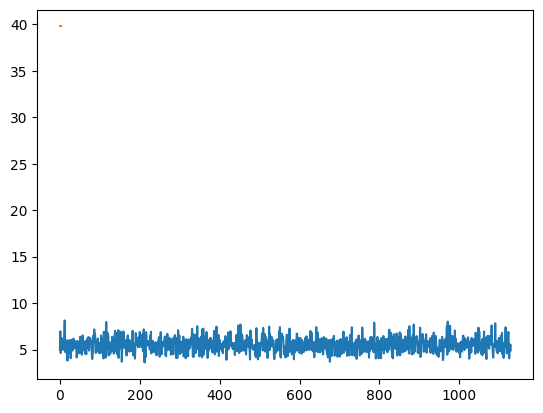

NeuralNet_default
-------------------- Epoch 0 --------------------
Train Epoch 0 | Average Training Loss 5.676853616680719
Validation set: Average loss: 7701.5498, Accuracy: 0/3612 (0%)

-------------------- Epoch 1 --------------------
Train Epoch 1 | Average Training Loss 5.678052945474608
Validation set: Average loss: 7701.5497, Accuracy: 0/3612 (0%)

-------------------- Epoch 2 --------------------
Train Epoch 2 | Average Training Loss 5.6773253099053305
Validation set: Average loss: 7701.5495, Accuracy: 0/3612 (0%)

-------------------- Epoch 3 --------------------
Train Epoch 3 | Average Training Loss 5.6784011125564575
Validation set: Average loss: 7701.5496, Accuracy: 0/3612 (0%)

-------------------- Epoch 4 --------------------
Train Epoch 4 | Average Training Loss 5.675820557417068
Validation set: Average loss: 7701.5496, Accuracy: 0/3612 (0%)



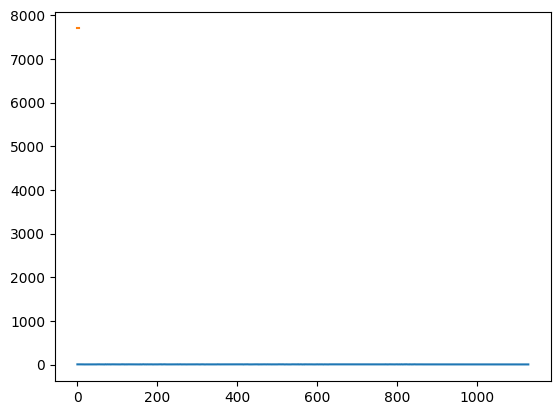

NeuralNet_deep_wider
-------------------- Epoch 0 --------------------
Train Epoch 0 | Average Training Loss 5.528126437052161
Validation set: Average loss: 1786.0977, Accuracy: 0/3612 (0%)

-------------------- Epoch 1 --------------------
Train Epoch 1 | Average Training Loss 5.529018732298792
Validation set: Average loss: 1786.0977, Accuracy: 0/3612 (0%)

-------------------- Epoch 2 --------------------
Train Epoch 2 | Average Training Loss 5.529485134951837
Validation set: Average loss: 1786.0977, Accuracy: 0/3612 (0%)

-------------------- Epoch 3 --------------------
Train Epoch 3 | Average Training Loss 5.528643545851243
Validation set: Average loss: 1786.0977, Accuracy: 0/3612 (0%)

-------------------- Epoch 4 --------------------
Train Epoch 4 | Average Training Loss 5.53010395881349
Validation set: Average loss: 1786.0977, Accuracy: 0/3612 (0%)



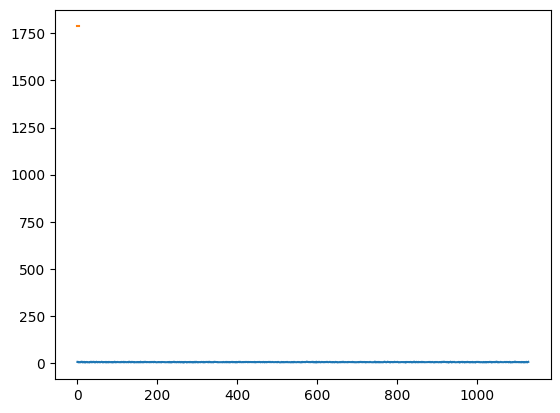

NeuralNet_deeper_wide
-------------------- Epoch 0 --------------------
Train Epoch 0 | Average Training Loss 5.747872284028382
Validation set: Average loss: 54.5572, Accuracy: 0/3612 (0%)

-------------------- Epoch 1 --------------------
Train Epoch 1 | Average Training Loss 5.746740777935602
Validation set: Average loss: 54.5572, Accuracy: 0/3612 (0%)

-------------------- Epoch 2 --------------------
Train Epoch 2 | Average Training Loss 5.746575836586741
Validation set: Average loss: 54.5572, Accuracy: 0/3612 (0%)

-------------------- Epoch 3 --------------------
Train Epoch 3 | Average Training Loss 5.74673737044883
Validation set: Average loss: 54.5572, Accuracy: 0/3612 (0%)

-------------------- Epoch 4 --------------------
Train Epoch 4 | Average Training Loss 5.7473753142145885
Validation set: Average loss: 54.5571, Accuracy: 0/3612 (0%)



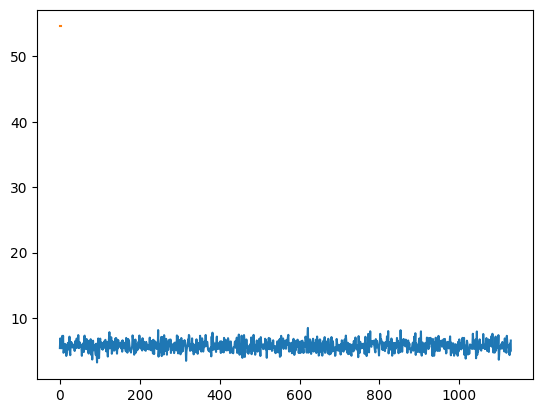

In [47]:
#evaluation of the different models
X_train_torch = torch.tensor(X_train,dtype=torch.float32)
y_train_torch = torch.tensor(y_train.reshape((len(y_train),1)),dtype=torch.float32)
X_validation_torch = torch.tensor(X_validation,dtype=torch.float32)
y_validation_torch = torch.tensor(y_validation.reshape((len(y_validation),1)),dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(X_train_torch,y_train_torch)
validation_dataset = torch.utils.data.TensorDataset(X_validation_torch,y_validation_torch)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=64, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu' # if you have a gpu, you can move the model onto it like this

all_models = NeuralNet_deep(), NeuralNet_wide(), NeuralNet_default(), NeuralNet_deep_wider(), NeuralNet_deeper_wide()

for model in all_models:
    print(model._get_name())
    train_loss, val_loss, val_accuracy = train_model(model,train_loader,val_loader,device)

    fig = plt.figure()
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.show()